# Index
* [Overview](#overview)
* [Cleaning](#cleaning)
* [Second Bullet Header](#second-bullet)

# Overview <a class="anchor" id="overview"></a>
* Investigate timing properties
    * What happenes with tasks with completion dates after 2015, but initiated in 2015?
        * A: <b>Completion date is recorded when available.</b> Main uncertainty is about requests with no completion dates. These might have to get discarded if there aren't too many - will be capped by request date for the dataset.
    * Are there duplicates between files from different years?
        * A: Looks like datasets are generated based on CreatedDate, so no duplicates across datasets.
        * <b>VERIFIED</b> No duplicate records.
    * Any dirty/odd data?
        * A: Yes... found a bunch of weird shit for different Date records:
            * CreatedDate is after ServiceDate & ClosedDate (much more common for ServiceDate)
            * Date of 1900 is used as a placeholder in 2015/2016 data - converting to NaT
            * About 100 records with ClosedDate = CreatedDate
            * Potential typos in recording the Year for records where ClosedDate is like a year before CreatedDate
    * How do completion times / request rates change by year and by NC?

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data2015 = pd.read_csv('MyLA311_Service_Request_Data_2015.csv')
data2016 = pd.read_csv('MyLA311_Service_Request_Data_2016.csv')
data2017 = pd.read_csv('MyLA311_Service_Request_Data_2017.csv')
data2018 = pd.read_csv('MyLA311_Service_Request_Data_2018.csv')

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning <a class="anchor" id="cleaning"></a>
## Quick look at data / some reformating

In [3]:
data2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237360 entries, 0 to 237359
Data columns (total 33 columns):
SRNumber              237360 non-null object
CreatedDate           237360 non-null object
UpdatedDate           237360 non-null object
ActionTaken           237360 non-null object
Owner                 237360 non-null object
RequestType           237360 non-null object
Status                237360 non-null object
RequestSource         237360 non-null object
MobileOS              33045 non-null object
Anonymous             237360 non-null object
AssignTo              236587 non-null object
ServiceDate           226264 non-null object
ClosedDate            218059 non-null object
AddressVerified       237360 non-null object
ApproximateAddress    237242 non-null object
Address               237325 non-null object
HouseNumber           227553 non-null float64
Direction             226677 non-null object
StreetName            227525 non-null object
Suffix                221973 non-n

In [4]:
data2015.describe()

HouseNumber        ZipCode       Latitude      Longitude  \
count  227553.000000  236979.000000  237116.000000  237116.000000   
mean     5932.957966   87146.343465      34.087400    -118.360531   
std      5653.972434   17221.232724       0.119465       0.107932   
min         1.000000       0.000000      33.706100    -118.667837   
25%      1322.000000   90026.000000      34.016186    -118.436565   
50%      4072.000000   90047.000000      34.079466    -118.331089   
75%      9226.000000   91331.000000      34.186939    -118.282358   
max     26612.000000   91607.000000      34.329347    -118.156139   

             TBMPage         TBMRow             CD             NC  
count  237104.000000  237104.000000  237104.000000  231532.000000  
mean      609.252366       4.046693       8.189229      57.190842  
std        82.864634       1.944407       4.221261      34.246471  
min       480.000000       1.000000       1.000000       4.000000  
25%       532.000000       2.000000       5.000000      25.000000  
50%       595.000000       4.000000       8.000000      55.000000  
75%       672.000000       6.000000      12.000000      84.000000  
max      4724.000000       7.000000      15.000000     125.000000

In [5]:
data2015.head()

SRNumber             CreatedDate             UpdatedDate ActionTaken  \
0  1-88226601  12/31/2015 09:59:26 PM  01/02/2016 02:29:52 PM  SR Created   
1  1-88226481  12/31/2015 08:15:44 PM  12/31/2015 08:21:03 PM  SR Created   
2  1-88226431  12/31/2015 08:02:50 PM  01/06/2016 09:38:51 AM  SR Created   
3  1-88214281  12/31/2015 06:59:28 PM  01/02/2016 09:04:07 AM  SR Created   
4  1-88213271  12/31/2015 06:58:38 PM  01/02/2016 09:02:10 AM  SR Created   

  Owner          RequestType     Status RequestSource MobileOS Anonymous  ...  \
0   BOS  Dead Animal Removal     Closed          Call      NaN         N  ...   
1   BOS  Dead Animal Removal  Cancelled          Call      NaN         N  ...   
2   BOS          Bulky Items     Closed          Call      NaN         N  ...   
3   BOS          Bulky Items     Closed         Email      NaN         N  ...   
4   BOS          Bulky Items     Closed         Email      NaN         N  ...   

                          Location TBMPage TBMColumn TBMRow  \
0  (34.2478180903, -118.280265306)   504.0         B    5.0   
1  (33.9789717768, -118.275261824)   674.0         C    7.0   
2  (34.1509935991, -118.443025561)   562.0         A    4.0   
3  (34.0459242166, -118.387599456)   632.0         H    5.0   
4  (34.0459242166, -118.387599456)   632.0         H    5.0   

                     APC   CD             CDMember    NC  \
0       North Valley APC  7.0       Felipe Fuentes  10.0   
1  South Los Angeles APC  9.0  Curren D. Price Jr.  86.0   
2       South Valley APC  4.0            David Ryu  26.0   
3   West Los Angeles APC  5.0                  NaN   NaN   
4   West Los Angeles APC  5.0          Paul Koretz  61.0   

                                              NCName    PolicePrecinct  
0                                 SUNLAND-TUJUNGA NC          FOOTHILL  
1  COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNI...            NEWTON  
2                                    SHERMAN OAKS NC          VAN NUYS  
3                                 SOUTH ROBERTSON NC               NaN  
4                                 SOUTH ROBERTSON NC  WEST LOS ANGELES  

[5 rows x 33 columns]

Converting date fields to DateTime and adding DateDiff fields for tracking report resolution times.
<br> Then, converting datediffs to days to maybe do some stats later.

In [6]:
dt_cols = ['CreatedDate','UpdatedDate','ServiceDate','ClosedDate']
for col in dt_cols:
    data2015[col] = pd.to_datetime(data2015[col])
    data2016[col] = pd.to_datetime(data2016[col])
    data2017[col] = pd.to_datetime(data2017[col])
    data2018[col] = pd.to_datetime(data2018[col])

Replacing placeholders marked by 1900-01-01 date by NaT. These only seem to appear in the ServiceDate (at least for 2015)

In [27]:
def fill_placeholder_1900(df):
    return df.replace(to_replace=pd.to_datetime('1900'),value=pd.NaT)

def fill_placeholder_1900_col(df):
    dt_cols = ['CreatedDate','UpdatedDate','ServiceDate','ClosedDate']
    for col in dt_cols:
        df[col] = df[col].replace(to_replace=pd.to_datetime('1900'),value=pd.NaT)

def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

### OK, I know this is ugly AF but just doing it.. will be in a nice pipeline later

In [22]:
fill_placeholder_1900_col(data2015)
fill_placeholder_1900_col(data2016)

In [26]:
#these don't seem to have placeholders anyways...
fill_placeholder_1900_col(data2017)
fill_placeholder_1900_col(data2018)

In [28]:
data2015['ClosedDiff'] = data2015.ClosedDate - data2015.CreatedDate
data2015['ServiceDiff'] = data2015.ServiceDate - data2015.CreatedDate
data2015['ClosedServiceDiff'] = data2015.ClosedDate - data2015.ServiceDate

In [30]:
data2016['ClosedDiff'] = data2016.ClosedDate - data2016.CreatedDate
data2016['ServiceDiff'] = data2016.ServiceDate - data2016.CreatedDate
data2016['ClosedServiceDiff'] = data2016.ClosedDate - data2016.ServiceDate

In [31]:
data2017['ClosedDiff'] = data2017.ClosedDate - data2017.CreatedDate
data2017['ServiceDiff'] = data2017.ServiceDate - data2017.CreatedDate
data2017['ClosedServiceDiff'] = data2017.ClosedDate - data2017.ServiceDate

In [32]:
data2018['ClosedDiff'] = data2018.ClosedDate - data2018.CreatedDate
data2018['ServiceDiff'] = data2018.ServiceDate - data2018.CreatedDate
data2018['ClosedServiceDiff'] = data2018.ClosedDate - data2018.ServiceDate

In [29]:
data2015['ClosedDiff_Days'] = data2015.ClosedDiff.apply(ddiff2days)
data2015['ServiceDiff_Days'] = data2015.ServiceDiff.apply(ddiff2days)
data2015['ClosedServiceDiff_Days'] = data2015.ClosedServiceDiff.apply(ddiff2days)

In [33]:
data2016['ClosedDiff_Days'] = data2016.ClosedDiff.apply(ddiff2days)
data2016['ServiceDiff_Days'] = data2016.ServiceDiff.apply(ddiff2days)
data2016['ClosedServiceDiff_Days'] = data2016.ClosedServiceDiff.apply(ddiff2days)

In [34]:
data2017['ClosedDiff_Days'] = data2017.ClosedDiff.apply(ddiff2days)
data2017['ServiceDiff_Days'] = data2017.ServiceDiff.apply(ddiff2days)
data2017['ClosedServiceDiff_Days'] = data2017.ClosedServiceDiff.apply(ddiff2days)

In [35]:
data2018['ClosedDiff_Days'] = data2018.ClosedDiff.apply(ddiff2days)
data2018['ServiceDiff_Days'] = data2018.ServiceDiff.apply(ddiff2days)
data2018['ClosedServiceDiff_Days'] = data2018.ClosedServiceDiff.apply(ddiff2days)

In [10]:
data2015.head()

SRNumber         CreatedDate         UpdatedDate ActionTaken Owner  \
0  1-88226601 2015-12-31 21:59:26 2016-01-02 14:29:52  SR Created   BOS   
1  1-88226481 2015-12-31 20:15:44 2015-12-31 20:21:03  SR Created   BOS   
2  1-88226431 2015-12-31 20:02:50 2016-01-06 09:38:51  SR Created   BOS   
3  1-88214281 2015-12-31 18:59:28 2016-01-02 09:04:07  SR Created   BOS   
4  1-88213271 2015-12-31 18:58:38 2016-01-02 09:02:10  SR Created   BOS   

           RequestType     Status RequestSource MobileOS Anonymous  ...  \
0  Dead Animal Removal     Closed          Call      NaN         N  ...   
1  Dead Animal Removal  Cancelled          Call      NaN         N  ...   
2          Bulky Items     Closed          Call      NaN         N  ...   
3          Bulky Items     Closed         Email      NaN         N  ...   
4          Bulky Items     Closed         Email      NaN         N  ...   

              CDMember    NC  \
0       Felipe Fuentes  10.0   
1  Curren D. Price Jr.  86.0   
2            David Ryu  26.0   
3                  NaN   NaN   
4          Paul Koretz  61.0   

                                              NCName    PolicePrecinct  \
0                                 SUNLAND-TUJUNGA NC          FOOTHILL   
1  COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNI...            NEWTON   
2                                    SHERMAN OAKS NC          VAN NUYS   
3                                 SOUTH ROBERTSON NC               NaN   
4                                 SOUTH ROBERTSON NC  WEST LOS ANGELES   

       ClosedDiff     ServiceDiff  ClosedServiceDiff ClosedDiff_Days  \
0 1 days 16:30:26             NaT                NaT        1.687801   
1             NaT             NaT                NaT             NaN   
2 5 days 13:36:01 5 days 03:57:10           09:38:51        5.566678   
3 1 days 14:04:39 1 days 05:00:32           09:04:07        1.586563   
4 1 days 14:03:33 1 days 05:01:22           09:02:11        1.585799   

  ServiceDiff_Days ClosedServiceDiff_Days  
0              NaN                    NaN  
1              NaN                    NaN  
2         5.164699               0.401979  
3         1.208704               0.377859  
4         1.209282               0.376516  

[5 rows x 39 columns]

Sure, we'll use the profiler to make the masses happy...

In [11]:
data2015.profile_report(style={'full_width':True})

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 4).')
  correlation_name=correlation_name, error=error


few more checks...

In [11]:
data2015.query('ClosedDiff_Days < 0')

SRNumber         CreatedDate         UpdatedDate ActionTaken Owner  \
20445   1-81100051 2015-12-15 13:38:00 2017-06-24 10:05:50  SR Created   BSL   
22866   1-80395391 2015-12-14 13:25:31 2018-01-23 13:55:56  SR Created   BSL   
28697   1-78368171 2015-12-09 16:06:26 2017-08-13 15:10:47  SR Created   BSL   
42627   1-74018081 2015-12-01 15:18:48 2019-04-02 09:50:11  SR Created   BSL   
80713   1-61427181 2015-11-04 15:26:39 2017-06-03 09:21:15  SR Created   BSL   
102312  1-55060171 2015-10-22 14:45:38 2018-01-17 13:06:17  SR Created   BSL   

                     RequestType  Status RequestSource MobileOS Anonymous  \
20445   Single Streetlight Issue  Closed         Email      NaN         N   
22866   Single Streetlight Issue  Closed         Email      NaN         N   
28697   Single Streetlight Issue  Closed          Call      NaN         N   
42627   Single Streetlight Issue  Closed          Call      NaN         Y   
80713   Single Streetlight Issue  Closed         Email      NaN         N   
102312  Single Streetlight Issue  Closed         Email      NaN         N   

        ...         CDMember     NC               NCName   PolicePrecinct  \
20445   ...  Bob Blumenfield   13.0       CANOGA PARK NC          TOPANGA   
22866   ...   Paul Krekorian   27.0       STUDIO CITY NC  NORTH HOLLYWOOD   
28697   ...   Felipe Fuentes  101.0     MISSION HILLS NC          MISSION   
42627   ...        David Ryu  119.0  GREATER WILSHIRE NC          OLYMPIC   
80713   ...    Nury Martinez    8.0   SUN VALLEY AREA NC         FOOTHILL   
102312  ...       Mike Bonin   68.0            VENICE NC          PACIFIC   

              ClosedDiff       ServiceDiff  ClosedServiceDiff ClosedDiff_Days  \
20445  -1 days +10:22:00 -1 days +10:22:00             0 days       -0.568056   
22866  -1 days +10:34:29 -1 days +10:34:29             0 days       -0.559387   
28697  -1 days +07:53:34 -1 days +07:53:34             0 days       -0.671134   
42627  -1 days +08:41:12 -1 days +08:41:12             0 days       -0.638056   
80713  -1 days +08:33:21 -1 days +08:33:21             0 days       -0.643507   
102312 -1 days +09:14:22 -1 days +09:14:22             0 days       -0.615023   

       ServiceDiff_Days ClosedServiceDiff_Days  
20445         -0.568056                    0.0  
22866         -0.559387                    0.0  
28697         -0.671134                    0.0  
42627         -0.638056                    0.0  
80713         -0.643507                    0.0  
102312        -0.615023                    0.0  

[6 rows x 39 columns]

Dafuq, ok, I guess maybe someone was overeager to close, fine.

In [12]:
data2015.query('ServiceDiff_Days <= 0').sort_values(by='ServiceDiff_Days',ascending=True)

SRNumber         CreatedDate         UpdatedDate ActionTaken Owner  \
178533  1-35529101 2015-09-11 11:28:40 2015-09-11 14:53:57  SR Created   BSL   
75460   1-63378521 2015-11-09 11:26:40 2015-11-29 18:52:02  SR Created   BSL   
219762  1-26514821 2015-08-17 09:40:53 2015-08-27 11:44:01  SR Created   BSL   
10228   1-84576181 2015-12-23 07:58:23 2015-12-28 15:59:03  SR Created   BSL   
36026   1-76286291 2015-12-06 12:25:53 2016-03-29 09:38:02  SR Created   BSS   
130453  1-47137141 2015-10-06 10:54:50 2016-03-29 10:58:17  SR Created   BSS   
117384  1-50812831 2015-10-14 09:50:18 2015-10-24 13:04:02  SR Created   BSL   
47145   1-72787741 2015-11-30 08:45:42 2016-03-29 11:00:02  SR Created   BSS   
192086  1-32612941 2015-09-02 15:30:59 2016-02-08 12:54:02  SR Created   BSS   
165828  1-38157081 2015-09-18 09:29:48 2015-09-28 07:08:58  SR Created   BSL   
45247   1-73270171 2015-11-30 14:50:42 2015-11-30 14:51:19  SR Created   BOS   
202732  1-30260431 2015-08-27 08:10:45 2015-09-18 06:58:53  SR Created   BSL   
141115  1-44135741 2015-09-30 09:18:56 2015-10-09 07:23:59  SR Created   BSL   
134840  1-45993981 2015-10-03 09:46:51 2015-10-09 07:23:59  SR Created   BSL   
15261   1-83042761 2015-12-19 08:28:47 2015-12-19 15:18:59  SR Created   BSL   
187733  1-33685521 2015-09-05 10:53:53 2015-11-27 13:55:37  SR Created   BOS   
134819  1-45997481 2015-10-03 09:52:16 2015-10-09 07:23:59  SR Created   BSL   
134832  1-45999141 2015-10-03 09:49:53 2015-10-09 07:18:53  SR Created   BSL   
134835  1-45993071 2015-10-03 09:48:49 2015-10-09 07:18:53  SR Created   BSL   
128128  1-47744681 2015-10-07 10:24:01 2015-10-09 07:23:59  SR Created   BSL   
107635  1-53492871 2015-10-20 08:57:25 2015-10-21 14:48:59  SR Created   BSL   
100957  1-55519061 2015-10-23 12:54:28 2016-02-10 08:55:12  SR Created   BSS   
198658  1-31269921 2015-08-30 12:24:05 2015-08-30 12:54:01  SR Created   BSL   
46588   1-72933631 2015-11-30 10:31:32 2015-12-15 16:29:03  SR Created   BSL   
134807  1-45997721 2015-10-03 09:54:57 2015-10-09 07:23:59  SR Created   BSL   
134809  1-45999691 2015-10-03 09:53:46 2015-10-09 07:23:59  SR Created   BSL   
35784   1-76380501 2015-12-07 07:40:40 2015-12-07 07:42:35  SR Created   BOS   
134863  1-45993211 2015-10-03 09:41:30 2015-10-09 07:18:53  SR Created   BSL   
21639   1-80770511 2015-12-15 09:01:09 2015-12-15 09:49:07  SR Created   BSL   
203403  1-30083311 2015-08-26 14:32:25 2015-08-26 15:33:58  SR Created   BSL   
...            ...                 ...                 ...         ...   ...   
84820   1-60242811 2015-11-03 06:53:54 2015-11-03 15:33:55  SR Created   BSL   
136433  1-45389031 2015-10-02 06:42:26 2015-10-09 07:23:59  SR Created   BSL   
136434  1-45388991 2015-10-02 06:41:33 2015-10-09 07:23:59  SR Created   BSL   
136435  1-45385891 2015-10-02 06:40:39 2015-10-09 07:23:59  SR Created   BSL   
136436  1-45388951 2015-10-02 06:39:50 2015-10-09 07:23:59  SR Created   BSL   
136437  1-45386651 2015-10-02 06:38:42 2015-10-09 07:23:59  SR Created   BSL   
136438  1-45385831 2015-10-02 06:37:42 2015-10-09 07:23:59  SR Created   BSL   
136439  1-45388881 2015-10-02 06:36:48 2015-10-09 07:23:59  SR Created   BSL   
136440  1-45385791 2015-10-02 06:36:09 2015-10-09 07:23:59  SR Created   BSL   
136441  1-45386621 2015-10-02 06:35:32 2015-10-09 07:23:59  SR Created   BSL   
136442  1-45384671 2015-10-02 06:34:55 2015-10-09 07:23:59  SR Created   BSL   
136443  1-45385741 2015-10-02 06:34:18 2015-10-09 07:23:59  SR Created   BSL   
136444  1-45385711 2015-10-02 06:31:27 2015-10-09 07:23:59  SR Created   BSL   
189752  1-33179011 2015-09-04 06:30:21 2015-09-09 00:44:00  SR Created   BSL   
189753  1-33181711 2015-09-04 06:28:27 2015-09-09 00:38:55  SR Created   BSL   
131328  1-46902611 2015-10-06 06:19:36 2015-10-09 07:23:59  SR Created   BSL   
189756  1-33178921 2015-09-04 06:15:35 2015-09-04 06:38:57  SR Created   BSL   
189758  1-33181601 2015-09-04 06:13:42 2015-09-04 06:34:02  SR Created   BSL   
189760  1-

jesus, dunno if service date is fucked or created date. Or are people creating reports after requests have been resoloved?

In [13]:
data2015.query('ClosedDiff_Days <= 0.').sort_values(by='ClosedDiff_Days',ascending=True)

SRNumber         CreatedDate         UpdatedDate ActionTaken  Owner  \
28697   1-78368171 2015-12-09 16:06:26 2017-08-13 15:10:47  SR Created    BSL   
80713   1-61427181 2015-11-04 15:26:39 2017-06-03 09:21:15  SR Created    BSL   
42627   1-74018081 2015-12-01 15:18:48 2019-04-02 09:50:11  SR Created    BSL   
102312  1-55060171 2015-10-22 14:45:38 2018-01-17 13:06:17  SR Created    BSL   
20445   1-81100051 2015-12-15 13:38:00 2017-06-24 10:05:50  SR Created    BSL   
22866   1-80395391 2015-12-14 13:25:31 2018-01-23 13:55:56  SR Created    BSL   
120238  1-49994671 2015-10-12 16:28:19 2015-10-12 16:28:19  SR Created  LADWP   
120539  1-49913961 2015-10-12 15:02:13 2015-10-12 15:02:13  SR Created  LADWP   
124596  1-48837811 2015-10-09 09:12:26 2015-10-09 09:12:26  SR Created  LADWP   
2175    1-87432181 2015-12-30 11:17:36 2015-12-30 11:17:36  SR Created  LADWP   
125339  1-48572421 2015-10-08 14:54:40 2015-10-08 14:54:40  SR Created  LADWP   
126503  1-48234441 2015-10-08 08:05:30 2015-10-08 08:05:30  SR Created  LADWP   
127342  1-47942701 2015-10-07 14:00:18 2015-10-07 14:00:18  SR Created  LADWP   
127629  1-47866971 2015-10-07 12:40:26 2015-10-07 12:40:26  SR Created  LADWP   
127930  1-47790241 2015-10-07 11:09:25 2015-10-07 11:09:25  SR Created  LADWP   
118673  1-50429451 2015-10-13 14:01:20 2015-10-13 14:01:20  SR Created  LADWP   
118190  1-50578771 2015-10-13 16:14:50 2015-10-13 16:14:50  SR Created  LADWP   
115395  1-51376371 2015-10-15 08:38:32 2015-10-15 08:38:32  SR Created  LADWP   
117217  1-50865791 2015-10-14 10:43:27 2015-10-14 10:43:27  SR Created  LADWP   
128561  1-47641991 2015-10-07 08:48:50 2015-10-07 08:48:50  SR Created  LADWP   
114600  1-51619301 2015-10-15 13:21:34 2015-10-15 13:21:34  SR Created  LADWP   
113703  1-51954421 2015-10-16 09:19:39 2015-10-16 09:19:39  SR Created  LADWP   
106586  1-53781201 2015-10-20 13:50:27 2015-10-20 13:50:27  SR Created  LADWP   
103155  1-54806111 2015-10-22 10:04:15 2015-10-22 10:04:15  SR Created  LADWP   
102870  1-54881531 2015-10-22 11:33:34 2015-10-22 11:33:34  SR Created  LADWP   
102760  1-54907391 2015-10-22 12:03:35 2015-10-22 12:03:35  SR Created  LADWP   
101722  1-55293881 2015-10-23 08:21:36 2015-10-23 08:21:36  SR Created  LADWP   
101692  1-55301911 2015-10-23 08:36:09 2015-10-23 08:36:09  SR Created  LADWP   
118111  1-50608561 2015-10-13 16:50:47 2015-10-13 16:50:47  SR Created  LADWP   
132684  1-46530291 2015-10-05 11:18:10 2015-10-05 11:18:10  SR Created  LADWP   
...            ...                 ...                 ...         ...    ...   
4372    1-86742741 2015-12-29 10:23:27 2015-12-29 10:23:27  SR Created  LADWP   
51129   1-71225871 2015-11-24 15:59:35 2015-11-24 15:59:35  SR Created  LADWP   
96400   1-56761691 2015-10-27 08:26:00 2015-10-27 08:26:00  SR Created  LADWP   
51451   1-71107871 2015-11-24 14:15:46 2015-11-24 14:15:46  SR Created  LADWP   
62459   1-67428491 2015-11-17 13:28:40 2015-11-17 13:28:40  SR Created  LADWP   
198503  1-31303951 2015-08-30 15:06:15 2015-08-30 15:06:15  SR Created  LADWP   
93961   1-57432211 2015-10-28 08:58:06 2015-10-28 08:58:06  SR Created  LADWP   
93106   1-57632921 2015-10-28 12:08:03 2015-10-28 12:08:03  SR Created  LADWP   
90999   1-58327131 2015-10-29 13:03:38 2015-10-29 13:03:38  SR Created  LADWP   
90573   1-58480891 2015-10-29 15:38:16 2015-10-29 15:38:16  SR Created  LADWP   
90124   1-58674501 2015-10-30 08:37:41 2015-10-30 08:37:41  SR Created  LADWP   
89516   1-58855441 2015-10-30 12:02:35 2015-10-30 12:02:35  SR Created  LADWP   
83496   1-60566051 2015-11-03 12:38:05 2015-11-03 12:38:05  SR Created  LADWP   
82753   1-60796021 2015-11-03 15:55:18 2015-11-03 15:55:18  SR Created  LADWP   
79141   1-61982951 2015-11-05 14:05:40 2015-11-05 14:05:40  SR Created  LADWP   
78138   1-62459041 2015-11-06 11:15:39 2015-11-06 11:15:39  SR Created  LADWP   
74651   1-63568311 2015-11-09 14:18:06 2015-11-09 14:18:06  SR Created  LADWP   
73092   1-64020061 2015-11-10 11:16:03 20

**initial pass**

WTF!! Ok... well we found a placeholder, people! "1900-01-01 00:00:00" (shoulda seen it in the report...); time to circle back and fix things. Not exactly clear what it's a placeholder for tho...
Seems to be only for ServiceDate and all items with this have status='Closed', ActionTaken='SR Created',RequestSource='Call', everything else seems standard...

Either way, can't use them for studying service time so gonna NaT em.

Also have a few serviced-in-2014 items

**second pass**

ClosedDate is sometimes (order of 100 times) identical to CreatedDate, so those are weird and I'll probably exclude from time estimations.

In [14]:
data2015.ClosedServiceDiff_Days.describe()

count    209048.000000
mean          1.838546
std          10.291698
min        -365.340995
25%           0.530984
50%           0.625208
75%           0.687778
max         538.587211
Name: ClosedServiceDiff_Days, dtype: float64

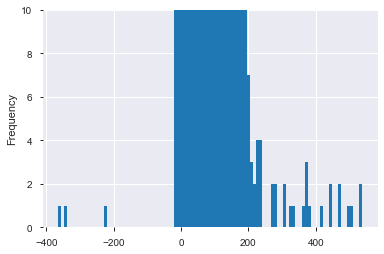

In [15]:
data2015.ClosedServiceDiff_Days.plot.hist(bins=100,ylim=(0,10))

Ok, so not there are some large differences between ServiceDate and ClosedDate- might drop/fix some of these eventually...

Cases when ServiceDate is > 30 days after ClosedDate look like might be typos... like ServiceDate needed to be 2016, but was recorded as 2015 (some 2015 vs 2014 too)...

**For now, going to just use median and mostly consider ClosedDate (ServiceDate might be ok, but would have to drop all of the negative ServiceDiff rows ~3000)**

In [16]:
data2016 = pd.read_csv('MyLA311_Service_Request_Data_2016.csv')

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
data2016.head()

SRNumber             CreatedDate             UpdatedDate ActionTaken  \
0  1-411056851  12/31/2016 11:51:57 PM  01/01/2017 09:18:37 AM  SR Created   
1  1-411056141  12/31/2016 11:39:03 PM  01/04/2017 05:56:28 PM  SR Created   
2  1-411057731  12/31/2016 11:37:22 PM  01/01/2017 07:21:52 AM  SR Created   
3  1-411056761  12/31/2016 11:32:09 PM  01/04/2017 05:39:50 PM  SR Created   
4  1-411056681  12/31/2016 11:30:51 PM  01/04/2017 05:52:09 PM  SR Created   

  Owner          RequestType     Status RequestSource MobileOS Anonymous  ...  \
0   BOS  Dead Animal Removal     Closed  Self Service      NaN         N  ...   
1   OCB     Graffiti Removal  Cancelled  Self Service      NaN         Y  ...   
2   BOS  Dead Animal Removal     Closed          Call      NaN         N  ...   
3   OCB     Graffiti Removal  Cancelled  Self Service      NaN         Y  ...   
4   OCB     Graffiti Removal  Cancelled  Self Service      NaN         Y  ...   

                          Location TBMPage TBMColumn TBMRow  \
0   (34.2340985645, -118.43673991)   502.0         B    7.0   
1  (34.0737138726, -118.272401627)   634.0         C    1.0   
2   (33.9988499952, -118.42044647)   672.0         D    4.0   
3  (34.0719937299, -118.273017652)   634.0         C    1.0   
4  (34.0733469063, -118.272617749)   634.0         C    1.0   

                    APC    CD         CDMember    NC  \
0      North Valley APC   6.0    Nury Martinez   6.0   
1  East Los Angeles APC  13.0  Mitch O'Farrell  44.0   
2  West Los Angeles APC  11.0       Mike Bonin  67.0   
3  East Los Angeles APC  13.0  Mitch O'Farrell  44.0   
4  East Los Angeles APC  13.0  Mitch O'Farrell  44.0   

                         NCName PolicePrecinct  
0                     ARLETA NC        MISSION  
1  GREATER ECHO PARK ELYSIAN NC        RAMPART  
2                  MAR VISTA CC        PACIFIC  
3  GREATER ECHO PARK ELYSIAN NC        RAMPART  
4  GREATER ECHO PARK ELYSIAN NC        RAMPART  

[5 rows x 33 columns]

In [20]:
data2017.sort_values(by='ServiceDate').ServiceDate
#for col in dt_cols:
#    data2016[col] = pd.to_datetime(data2016[col])
#    data2017[col] = pd.to_datetime(data2017[col])
#    data2018[col] = pd.to_datetime(data2018[col])
#data2016['ClosedDiff'] = data2016.ClosedDate - data2016.CreatedDate
#data2016['ServiceDiff'] = data2016.ServiceDate - data2016.CreatedDate
#data2016['ClosedServiceDiff'] = data2016.ClosedDate - data2016.ServiceDate

#data2016['ClosedDiff_Days'] = data2016.ClosedDiff.apply(ddiff2days)
#data2016['ServiceDiff_Days'] = data2016.ServiceDiff.apply(ddiff2days)
#data2016['ClosedServiceDiff_Days'] = data2016.ClosedServiceDiff.apply(ddiff2days)

940536    2007-03-16 00:00:00
548326    2014-07-14 00:00:00
479022    2015-01-03 00:00:00
479025    2015-01-03 00:00:00
479028    2015-01-03 00:00:00
479037    2015-01-03 00:00:00
479029    2015-01-03 00:00:00
479030    2015-01-03 00:00:00
479032    2015-01-03 00:00:00
479034    2015-01-03 00:00:00
479035    2015-01-03 00:00:00
479036    2015-01-03 00:00:00
478993    2015-01-03 13:33:21
478994    2015-01-03 13:33:21
478995    2015-01-03 13:33:21
479005    2015-01-03 13:33:21
478992    2015-01-03 13:33:21
479004    2015-01-03 13:33:21
479010    2015-01-03 13:33:21
479009    2015-01-03 13:33:21
479006    2015-01-03 13:33:21
479013    2015-01-03 13:33:21
479015    2015-01-03 13:33:21
479017    2015-01-03 13:33:21
478999    2015-01-03 13:33:21
479019    2015-01-03 13:33:21
468309    2015-02-16 00:00:00
468313    2015-02-16 00:00:00
468316    2015-02-16 00:00:00
468314    2015-02-16 00:00:00
                  ...        
1131595                   NaT
1131603                   NaT
1131610   

In [24]:
def fill_placeholder_1900_col(df):
    dt_cols = ['CreatedDate','UpdatedDate','ServiceDate','ClosedDate']
    for col in dt_cols:
        df[col] = df[col].replace(to_replace=pd.to_datetime('1900'),value=pd.NaT)

In [ ]:
fill_placeholder_1900_col(data2016)

In [27]:
data2015 = fill_placeholder_1900(data2015)

Empty DataFrame
Columns: [SRNumber, CreatedDate, UpdatedDate, ActionTaken, Owner, RequestType, Status, RequestSource, MobileOS, Anonymous, AssignTo, ServiceDate, ClosedDate, AddressVerified, ApproximateAddress, Address, HouseNumber, Direction, StreetName, Suffix, ZipCode, Latitude, Longitude, Location, TBMPage, TBMColumn, TBMRow, APC, CD, CDMember, NC, NCName, PolicePrecinct]
Index: []

[0 rows x 33 columns]

In [48]:
data2017.query('CreatedDate < 2018 & ClosedDate > 2018')

SRNumber         CreatedDate         UpdatedDate ActionTaken  \
0        1-870704831 2017-12-31 23:59:58 2018-04-09 09:25:28  SR Created   
1        1-870694601 2017-12-31 23:56:39 2018-01-03 10:11:23  SR Created   
2        1-870693641 2017-12-31 23:53:39 2018-01-03 10:12:06  SR Created   
3        1-870703871 2017-12-31 23:51:08 2018-01-03 10:11:36  SR Created   
4        1-870699049 2017-12-31 23:50:59 2018-01-02 20:28:48  SR Created   
5        1-870699071 2017-12-31 23:50:56 2018-01-02 14:40:00  SR Created   
6        1-870693501 2017-12-31 23:46:28 2018-01-03 10:12:00  SR Created   
7        1-870693311 2017-12-31 23:41:12 2018-01-04 09:12:16  SR Created   
8        1-870692591 2017-12-31 23:18:48 2018-01-02 13:29:41  SR Created   
9        1-870693181 2017-12-31 23:14:35 2018-01-06 08:51:07  SR Created   
10       1-870693061 2017-12-31 23:09:26 2018-01-04 10:14:12  SR Created   
11       1-870698801 2017-12-31 22:55:00 2018-01-02 17:36:54  SR Created   
12       1-870692381 2017-12-31 22:39:19 2018-01-04 15:01:02  SR Created   
13       1-870692279 2017-12-31 22:38:41 2018-01-02 21:46:13  SR Created   
14       1-870692171 2017-12-31 22:31:43 2018-01-03 13:14:01  SR Created   
15       1-870692121 2017-12-31 22:30:43 2018-01-01 13:36:38  SR Created   
16       1-870686541 2017-12-31 22:29:11 2018-01-03 07:28:15  SR Created   
17       1-870693851 2017-12-31 22:27:29 2018-01-03 07:30:37  SR Created   
18       1-870692011 2017-12-31 22:26:08 2018-01-03 07:40:24  SR Created   
19       1-870691901 2017-12-31 22:23:38 2018-01-03 07:37:44  SR Created   
20       1-870682691 2017-12-31 22:11:31 2018-01-04 12:51:55  SR Created   
21       1-870681581 2017-12-31 22:08:15 2018-03-09 10:33:32  SR Created   
22       1-870687684 2017-12-31 22:05:12 2018-01-01 13:28:23  SR Created   
23       1-870686271 2017-12-31 21:51:56 2018-01-08 17:22:34  SR Created   
24       1-870687611 2017-12-31 21:51:10 2018-01-03 16:18:10  SR Created   
25       1-870682541 2017-12-31 21:48:02 2018-01-02 16:45:57  SR Created   
26       1-870686191 2017-12-31 21:45:21 2018-01-02 16:23:43  SR Created   
27       1-870687481 2017-12-31 21:42:47 2018-01-02 09:23:14  SR Created   
28       1-870682431 2017-12-31 21:38:41 2018-01-02 10:58:12  SR Created   
29       1-870687381 2017-12-31 21:35:58 2018-01-06 12:34:19  SR Created   
...              ...                 ...                 ...         ...   
1079481  1-429426601 2017-01-20 08:28:31 2018-05-26 10:07:11  SR Created   
1079705  1-429276311 2017-01-19 23:39:19 2018-05-26 10:08:40  SR Created   
1083261  1-427878385 2017-01-18 21:01:46 2018-07-25 15:05:04  SR Created   
1085702  1-427045041 2017-01-18 10:51:30 2019-09-12 08:40:14  SR Created   
1086204  1-426911591 2017-01-18 09:53:32 2019-08-26 06:50:23  SR Created   
1087078  1-426610521 2017-01-17 23:25:29 2018-02-15 06:27:30  SR Created   
1087094  1-426600201 2017-01-17 22:47:49 2018-02-15 06:27:08  SR Created   
1092459  1-424859311 2017-01-16 14:06:42 2018-05-26 10:10:30  SR Created   
1092620  1-424798651 2017-01-16 13:28:54 2018-05-26 10:12:59  SR Created   
1093337  1-424503783 2017-01-16 10:27:39 2018-02-15 06:22:26  SR Created   
1094038  1-424208955 2017-01-16 02:48:11 2018-05-14 15:08:46  SR Created   
1095026  1-423959401 2017-01-15 10:32:39 2018-02-15 06:21:41  SR Created   
1095593  1-423788531 2017-01-14 15:45:02 2018-06-09 10:40:42  SR Created   
1096095  1-423633321 2017-01-14 11:13:41 2018-05-26 10:22:29  SR Created   
1096123  1-423622441 2017-01-14 10:55:56 2018-05-26 10:25:07  SR Created   
1096492  1-423488881 2017-01-13 20:15:40 2018-05-26 10:26:44  SR Created   
1098363  1-422421491 2017-01-12 19:55:13 2018-02-15 06:21:21  SR Created   
1102102  1-420924833 2017-01-11 13:52:32 2019-03-27 10:20:56  SR Created   
1108001  1-419046331 2017-01-10 09:17:10 2018-02-15 06:16:21  SR Created   
1108422  1-418914761 2017-01-10 07:59:31 2018-02-15 06:21:02  SR Created   
1109124  1-418713861 2017-01-09 17:01:44 2018-01-12 07:36:30

In [49]:
data2016.query('CreatedDate < 2017 & ClosedDate > 2017')

SRNumber         CreatedDate         UpdatedDate ActionTaken Owner  \
0       1-411056851 2016-12-31 23:51:57 2017-01-01 09:18:37  SR Created   BOS   
2       1-411057731 2016-12-31 23:37:22 2017-01-01 07:21:52  SR Created   BOS   
6       1-411062521 2016-12-31 23:26:02 2017-01-04 17:55:29  SR Created   OCB   
7       1-411056041 2016-12-31 23:23:13 2017-01-13 16:17:50  SR Created   OCB   
9       1-411056601 2016-12-31 23:07:40 2017-01-04 10:01:29  SR Created   OCB   
10      1-411055901 2016-12-31 22:19:08 2017-01-07 09:41:57  SR Created   BOS   
11      1-411055821 2016-12-31 22:18:53 2017-01-03 07:30:04  SR Created   OCB   
12      1-411054151 2016-12-31 22:14:44 2017-01-03 07:31:10  SR Created   OCB   
13      1-411049404 2016-12-31 22:08:29 2017-01-07 13:18:58  SR Created   BOS   
14      1-411055701 2016-12-31 22:07:04 2017-01-03 12:55:00  SR Created   BOS   
15      1-411055631 2016-12-31 22:06:40 2017-01-03 12:19:50  SR Created   BOS   
16      1-411049251 2016-12-31 22:04:59 2017-01-03 09:02:09  SR Created   BOS   
17      1-411055521 2016-12-31 22:02:40 2017-01-03 10:32:14  SR Created   BOS   
18      1-411053901 2016-12-31 22:00:56 2017-01-04 08:19:20  SR Created   BOS   
19      1-411044411 2016-12-31 21:54:57 2017-01-05 09:26:41  SR Created   BOS   
20      1-411049051 2016-12-31 21:51:12 2017-01-01 11:00:12  SR Created   BOS   
21      1-411048981 2016-12-31 21:48:15 2017-01-04 08:20:06  SR Created   BOS   
22      1-411044321 2016-12-31 21:34:03 2017-01-05 10:05:54  SR Created   BOS   
23      1-411048221 2016-12-31 21:21:52 2017-01-01 13:15:41  SR Created   BOS   
24      1-411048871 2016-12-31 21:20:32 2017-01-04 14:29:40  SR Created   BOS   
25      1-411053631 2016-12-31 21:19:20 2017-01-04 09:10:46  SR Created   BOS   
26      1-411048131 2016-12-31 21:18:57 2017-01-09 08:52:38  SR Created   BOS   
27      1-411053521 2016-12-31 21:17:17 2017-01-02 15:29:35  SR Created   OCB   
28      1-411048031 2016-12-31 21:15:08 2017-01-06 15:16:09  SR Created   OCB   
29      1-411047826 2016-12-31 21:02:13 2017-01-06 15:39:18  SR Created   BOS   
30      1-411048611 2016-12-31 21:02:08 2017-01-05 08:08:26  SR Created   BOS   
31      1-411045371 2016-12-31 20:57:16 2017-01-02 15:41:02  SR Created   OCB   
32      1-411047831 2016-12-31 20:56:20 2017-01-06 13:22:24  SR Created   BOS   
33      1-411047749 2016-12-31 20:52:30 2017-01-07 14:16:04  SR Created   BOS   
34      1-411042491 2016-12-31 20:23:48 2017-01-04 09:20:33  SR Created   BOS   
...             ...                 ...                 ...         ...   ...   
915604  1-101013071 2016-01-20 11:27:09 2017-11-17 13:13:58  SR Created   OCB   
917094  1-100547436 2016-01-19 17:37:12 2017-03-12 11:20:42  SR Created   BSL   
918666  1-100023142 2016-01-19 11:37:03 2018-03-01 14:08:06  SR Created   OCB   
918960   1-99938361 2016-01-19 10:54:59 2017-11-17 13:12:58  SR Created   OCB   
919640   1-99749381 2016-01-19 09:24:39 2017-02-15 22:10:18  SR Created   BSL   
919695   1-99720771 2016-01-19 09:17:13 2017-11-16 14:58:23  SR Created   OCB   
919700   1-99732681 2016-01-19 09:16:40 2017-11-16 14:57:37  SR Created   OCB   
919706   1-99731351 2016-01-19 09:16:09 2017-11-16 14:52:54  SR Created   OCB   
919722   1-99718191 2016-01-19 09:15:25 2017-11-16 14:52:22  SR Created   OCB   
920276   1-99523981 2016-01-18 22:35:39 2018-02-10 08:28:05  SR Created   OCB   
921803   1-99118731 2016-01-18 11:29:47 2017-11-16 14:51:44  SR Created   OCB   
922174   1-99015831 2016-01-18 10:14:24 2017-11-16 14:50:24  SR Created   OCB   
922257   1-98984991 2016-01-18 09:48:50 2017-11-21 14:15:42  SR Created   OCB   
922436   1-98940651 2016-01-18 09:16:15 2017-11-22 08:42:30  SR Created   OCB   
922706   1-98861451 2016-01-18 07:58:57 2018-02-10 07:56:43  SR Created   OCB   
922815   1-98794091 2016-01-17 20:33:21 2018-02-07 07:36:08  SR Created   OCB   
922883   1-98778471 2016-01-17 17:30:58 2018-01-20 09:21:45  SR Created   OCB   
924627   1-98220081 2016-01-15 19:42:26 20

In [50]:
data2015.query('CreatedDate < 2016 & ClosedDate > 2016')

SRNumber         CreatedDate         UpdatedDate ActionTaken Owner  \
0       1-88226601 2015-12-31 21:59:26 2016-01-02 14:29:52  SR Created   BOS   
2       1-88226431 2015-12-31 20:02:50 2016-01-06 09:38:51  SR Created   BOS   
3       1-88214281 2015-12-31 18:59:28 2016-01-02 09:04:07  SR Created   BOS   
4       1-88213271 2015-12-31 18:58:38 2016-01-02 09:02:10  SR Created   BOS   
5       1-88212231 2015-12-31 18:29:39 2016-01-04 15:51:10  SR Created   BOS   
6       1-88213191 2015-12-31 18:28:32 2016-01-04 12:35:35  SR Created   BOS   
7       1-88218911 2015-12-31 18:27:14 2016-01-04 10:52:30  SR Created   BOS   
8       1-88218741 2015-12-31 18:14:19 2016-01-06 12:33:06  SR Created   BOS   
9       1-88213931 2015-12-31 18:13:04 2016-01-06 10:48:48  SR Created   BOS   
10      1-88213651 2015-12-31 17:52:33 2016-01-02 09:40:19  SR Created   BOS   
11      1-88218451 2015-12-31 17:46:09 2016-01-04 13:56:21  SR Created   BOS   
12      1-88218401 2015-12-31 17:43:53 2016-01-02 09:07:53  SR Created   BOS   
14      1-88212671 2015-12-31 17:43:10 2016-01-02 10:20:04  SR Created   BOS   
15      1-88213361 2015-12-31 17:24:12 2016-01-02 09:54:51  SR Created   BOS   
16      1-88212471 2015-12-31 17:21:47 2016-01-02 08:08:05  SR Created   BOS   
17      1-88209271 2015-12-31 17:18:15 2016-01-02 09:10:29  SR Created   BOS   
18      1-88212411 2015-12-31 17:16:52 2016-01-02 11:06:50  SR Created   BOS   
19      1-88209201 2015-12-31 17:16:00 2016-01-02 11:05:37  SR Created   BOS   
20      1-88209061 2015-12-31 16:52:01 2016-01-07 11:43:52  SR Created   BOS   
21      1-88209971 2015-12-31 16:50:24 2016-01-07 12:53:04  SR Created   BOS   
22      1-88209911 2015-12-31 16:48:31 2016-01-07 12:16:19  SR Created   BOS   
23      1-88207261 2015-12-31 16:47:03 2016-01-07 09:41:29  SR Created   BOS   
24      1-88208911 2015-12-31 16:47:03 2016-01-04 16:53:48  SR Created   BOS   
25      1-88209761 2015-12-31 16:42:21 2016-01-02 08:09:49  SR Created   BOS   
26      1-88209711 2015-12-31 16:42:11 2016-01-02 08:56:13  SR Created   BOS   
27      1-88207131 2015-12-31 16:42:00 2016-01-04 13:20:34  SR Created   BOS   
28      1-88207911 2015-12-31 16:41:47 2016-01-02 09:36:05  SR Created   BOS   
29      1-88207061 2015-12-31 16:41:19 2016-01-05 10:25:01  SR Created   BOS   
30      1-88207761 2015-12-31 16:38:32 2016-01-06 12:39:13  SR Created   BOS   
31      1-88209521 2015-12-31 16:37:35 2016-01-06 11:29:23  SR Created   BOS   
...            ...                 ...                 ...         ...   ...   
219365  1-26586331 2015-08-17 11:13:40 2016-01-28 14:59:01  SR Created   BSL   
219375  1-26580111 2015-08-17 11:10:59 2016-02-01 06:53:57  SR Created   BSL   
219379  1-26579021 2015-08-17 11:10:13 2016-05-23 13:39:09  SR Created   BOS   
219547  1-26552571 2015-08-17 10:28:14 2016-05-23 13:46:09  SR Created   BOS   
219779  1-26515341 2015-08-17 09:38:12 2016-01-19 19:48:39  SR Created   BSS   
220484  1-26356181 2015-08-16 10:28:17 2016-01-19 19:39:30  SR Created   BSS   
220497  1-26357571 2015-08-16 09:58:41 2016-01-28 10:09:00  SR Created   BSL   
220854  1-26214511 2015-08-15 13:15:02 2016-01-13 11:38:41  SR Created   BSS   
223593  1-25467131 2015-08-13 12:11:08 2016-01-19 20:02:50  SR Created   BSS   
223748  1-25443621 2015-08-13 11:36:59 2016-03-29 14:05:39  SR Created   BSS   
224247  1-25339691 2015-08-13 09:20:13 2016-03-29 13:31:17  SR Created   BSS   
224403  1-25303981 2015-08-13 08:34:46 2016-08-12 11:29:07  SR Created   BOS   
225655  1-25020441 2015-08-12 12:04:28 2016-01-08 16:43:43  SR Created   BSS   
225717  1-25010391 2015-08-12 11:44:55 2016-01-12 16:57:56  SR Created   BSS   
226227  1-24913161 2015-08-12 09:38:56 2016-03-29 09:34:29  SR Created   BSS   
226389  1-24886271 2015-08-12 09:02:24 2016-11-11 10:44:34  SR Created   BOS   
226645  1-24844821 2015-08-12 07:51:17 2016-01-19 19:27:18  SR Created   BSS   
228082  1-24545701 2015-08-11 12:16:33 2016-01-19 19:06:03  SR Created   BSS   
228336  1-

In [51]:
data2018.query('CreatedDate < 2019 & ClosedDate > 2019')

SRNumber         CreatedDate         UpdatedDate ActionTaken  \
0        1-1262691971 2018-12-31 23:55:30 2019-01-02 22:20:06  SR Created   
1        1-1262694361 2018-12-31 23:53:51 2019-01-04 14:37:07  SR Created   
2        1-1262691941 2018-12-31 23:50:04 2019-01-15 11:11:39  SR Created   
3        1-1262691921 2018-12-31 23:43:07 2019-01-02 11:10:40  SR Created   
4        1-1262694331 2018-12-31 23:40:14 2019-01-02 09:55:16  SR Created   
5        1-1262692671 2018-12-31 23:38:38 2019-01-02 22:18:30  SR Created   
6        1-1262691891 2018-12-31 23:38:37 2019-01-02 11:29:02  SR Created   
7        1-1262692651 2018-12-31 23:36:58 2019-01-02 11:22:30  SR Created   
8        1-1262693411 2018-12-31 23:24:15 2019-01-09 19:21:49  SR Created   
9        1-1262694271 2018-12-31 23:22:40 2019-01-02 12:40:41  SR Created   
10       1-1262691801 2018-12-31 23:10:53 2019-01-07 16:00:12  SR Created   
11       1-1262691761 2018-12-31 23:03:18 2019-01-01 09:18:54  SR Created   
12       1-1262692561 2018-12-31 22:55:14 2019-01-07 16:00:12  SR Created   
13       1-1262692541 2018-12-31 22:50:56 2019-08-23 11:24:02  SR Created   
14       1-1262694181 2018-12-31 22:49:15 2019-01-02 22:16:37  SR Created   
15       1-1262692511 2018-12-31 22:47:49 2019-01-02 13:23:03  SR Created   
16       1-1262692481 2018-12-31 22:44:30 2019-01-04 11:46:43  SR Created   
17       1-1262691661 2018-12-31 22:36:15 2019-01-07 11:40:15  SR Created   
18       1-1262692441 2018-12-31 22:35:14 2019-01-04 15:49:21  SR Created   
19       1-1262694131 2018-12-31 22:34:33 2019-01-02 13:28:16  SR Created   
20       1-1262694101 2018-12-31 22:33:31 2019-01-14 17:38:44  SR Created   
21       1-1262692391 2018-12-31 22:31:06 2019-01-02 22:13:57  SR Created   
22       1-1262692371 2018-12-31 22:29:57 2019-01-05 13:29:31  SR Created   
23       1-1262687041 2018-12-31 22:29:00 2019-01-07 10:00:20  SR Created   
24       1-1262692351 2018-12-31 22:28:04 2019-01-05 09:50:04  SR Created   
25       1-1262693191 2018-12-31 22:26:58 2019-01-03 10:53:59  SR Created   
27       1-1262693121 2018-12-31 22:22:14 2019-01-07 13:17:25  SR Created   
28       1-1262686911 2018-12-31 22:21:13 2019-01-02 15:14:09  SR Created   
29       1-1262692211 2018-12-31 22:16:28 2019-01-05 09:13:44  SR Created   
30       1-1262686831 2018-12-31 22:14:10 2019-01-05 09:13:37  SR Created   
...               ...                 ...                 ...         ...   
1000107   1-952719784 2018-03-03 18:23:14 2019-03-21 07:47:22  SR Created   
1003864   1-951360141 2018-03-01 17:48:09 2019-07-27 09:45:47  SR Created   
1016037   1-947257351 2018-02-26 16:24:59 2019-01-14 15:50:50  SR Created   
1017246   1-946971431 2018-02-26 14:14:25 2019-08-26 06:50:46  SR Created   
1023235   1-944162171 2018-02-23 11:13:36 2019-08-28 13:51:27  SR Created   
1023514   1-943869961 2018-02-23 10:00:48 2019-02-21 12:58:07  SR Created   
1041496   1-935064430 2018-02-16 16:29:19 2019-08-23 09:20:18  SR Created   
1045485   1-933244091 2018-02-15 12:55:55 2019-06-07 10:17:29  SR Created   
1046485   1-932706731 2018-02-15 09:24:20 2019-02-14 12:30:10  SR Created   
1052337   1-930440791 2018-02-13 14:42:22 2019-05-24 13:40:09  SR Created   
1052714   1-930306761 2018-02-13 13:48:00 2019-06-06 09:28:55  SR Created   
1062477   1-926395769 2018-02-09 17:33:50 2019-02-05 07:51:04  SR Created   
1063377   1-925992291 2018-02-09 13:59:18 2019-02-12 10:59:15  SR Created   
1071730   1-922534911 2018-02-07 13:52:38 2019-02-12 10:26:57  SR Created   
1071761   1-922521041 2018-02-07 13:47:13 2019-08-28 13:51:26  SR Created   
1079293   1-919636221 2018-02-06 07:25:45 2019-01-30 10:00:17  SR Created   
1097637   1-911679071 2018-01-30 15:28:16 2019-01-24 10:16:15  SR Created   
1109526   1-907082191 2018-01-26 15:42:42 2019-08-15 09:21:14  SR Created   
1110828   1-906473871 2018-01-26 11:17:43 2019-01-02 15:04:33  SR Created   
1115402   1-904100093 2018-01-25 05:42:46 2019-02-22 16:00:39  SR Created   
1120206  

Checking for identical SRNumbers between different datasets (for potential duplicates)

In [41]:
pd.merge(data2015, data2016, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [42]:
pd.merge(data2016, data2017, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [43]:
pd.merge(data2017, data2018, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [44]:
pd.merge(data2015, data2017, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [45]:
pd.merge(data2015, data2018, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [46]:
pd.merge(data2016, data2017, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

In [47]:
pd.merge(data2016, data2018, on=['SRNumber'], how='inner')

Empty DataFrame
Columns: [SRNumber, CreatedDate_x, UpdatedDate_x, ActionTaken_x, Owner_x, RequestType_x, Status_x, RequestSource_x, MobileOS_x, Anonymous_x, AssignTo_x, ServiceDate_x, ClosedDate_x, AddressVerified_x, ApproximateAddress_x, Address_x, HouseNumber_x, Direction_x, StreetName_x, Suffix_x, ZipCode_x, Latitude_x, Longitude_x, Location_x, TBMPage_x, TBMColumn_x, TBMRow_x, APC_x, CD_x, CDMember_x, NC_x, NCName_x, PolicePrecinct_x, ClosedDiff_x, ServiceDiff_x, ClosedServiceDiff_x, ClosedDiff_Days_x, ServiceDiff_Days_x, ClosedServiceDiff_Days_x, CreatedDate_y, UpdatedDate_y, ActionTaken_y, Owner_y, RequestType_y, Status_y, RequestSource_y, MobileOS_y, Anonymous_y, AssignTo_y, ServiceDate_y, ClosedDate_y, AddressVerified_y, ApproximateAddress_y, Address_y, HouseNumber_y, Direction_y, StreetName_y, Suffix_y, ZipCode_y, Latitude_y, Longitude_y, Location_y, TBMPage_y, TBMColumn_y, TBMRow_y, APC_y, CD_y, CDMember_y, NC_y, NCName_y, PolicePrecinct_y, ClosedDiff_y, ServiceDiff_y, ClosedServiceDiff_y, ClosedDiff_Days_y, ServiceDiff_Days_y, ClosedServiceDiff_Days_y]
Index: []

[0 rows x 77 columns]

Checking for any CreatedDates that are outside of the year for each dataset

In [37]:
data2015.query('CreatedDate < 2015 | CreatedDate > 2016')

Empty DataFrame
Columns: [SRNumber, CreatedDate, UpdatedDate, ActionTaken, Owner, RequestType, Status, RequestSource, MobileOS, Anonymous, AssignTo, ServiceDate, ClosedDate, AddressVerified, ApproximateAddress, Address, HouseNumber, Direction, StreetName, Suffix, ZipCode, Latitude, Longitude, Location, TBMPage, TBMColumn, TBMRow, APC, CD, CDMember, NC, NCName, PolicePrecinct, ClosedDiff, ServiceDiff, ClosedServiceDiff, ClosedDiff_Days, ServiceDiff_Days, ClosedServiceDiff_Days]
Index: []

[0 rows x 39 columns]

In [38]:
data2016.query('CreatedDate < 2016 | CreatedDate > 2017')

Empty DataFrame
Columns: [SRNumber, CreatedDate, UpdatedDate, ActionTaken, Owner, RequestType, Status, RequestSource, MobileOS, Anonymous, AssignTo, ServiceDate, ClosedDate, AddressVerified, ApproximateAddress, Address, HouseNumber, Direction, StreetName, Suffix, ZipCode, Latitude, Longitude, Location, TBMPage, TBMColumn, TBMRow, APC, CD, CDMember, NC, NCName, PolicePrecinct, ClosedDiff, ServiceDiff, ClosedServiceDiff, ClosedDiff_Days, ServiceDiff_Days, ClosedServiceDiff_Days]
Index: []

[0 rows x 39 columns]

In [39]:
data2017.query('CreatedDate < 2017 | CreatedDate > 2018')

Empty DataFrame
Columns: [SRNumber, CreatedDate, UpdatedDate, ActionTaken, Owner, RequestType, Status, RequestSource, MobileOS, Anonymous, AssignTo, ServiceDate, ClosedDate, AddressVerified, ApproximateAddress, Address, HouseNumber, Direction, StreetName, Suffix, ZipCode, Latitude, Longitude, Location, TBMPage, TBMColumn, TBMRow, APC, CD, CDMember, NC, NCName, PolicePrecinct, ClosedDiff, ServiceDiff, ClosedServiceDiff, ClosedDiff_Days, ServiceDiff_Days, ClosedServiceDiff_Days]
Index: []

[0 rows x 39 columns]

In [40]:
data2018.query('CreatedDate < 2018 | CreatedDate > 2019')

Empty DataFrame
Columns: [SRNumber, CreatedDate, UpdatedDate, ActionTaken, Owner, RequestType, Status, RequestSource, MobileOS, Anonymous, AssignTo, ServiceDate, ClosedDate, AddressVerified, ApproximateAddress, Address, HouseNumber, Direction, StreetName, Suffix, ZipCode, Latitude, Longitude, Location, TBMPage, TBMColumn, TBMRow, APC, CD, CDMember, NC, NCName, PolicePrecinct, ClosedDiff, ServiceDiff, ClosedServiceDiff, ClosedDiff_Days, ServiceDiff_Days, ClosedServiceDiff_Days]
Index: []

[0 rows x 39 columns]